# Topic Clustering Details

## Contents

1. [Overview](#Overview)
1. [Your projects](#Your-projects)
1. [Set-up](#Set-up)
1. [Data organization](#Data-organization)
  1. [Train/dev/test](#Train/dev/test)
  1. [No fixed splits](#No-fixed-splits)
1. [Cross-validation](#Cross-validation)
  1. [Random splits](#Random-splits)
  1. [K-folds](#K-folds)
1. [Baselines](#Baselines)
  1. [Baselines are crucial for strong experiments](#Baselines-are-crucial-for-strong-experiments)
  1. [Random baselines](#Random-baselines)
  1. [Task-specific baselines](#Task-specific-baselines)
1. [Hyperparameter optimization](#Hyperparameter-optimization)
  1. [Rationale](#Rationale)
  1. [The ideal hyperparameter optimization setting](#The-ideal-hyperparameter-optimization-setting)
  1. [Practical considerations, and some compromises](#Practical-considerations,-and-some-compromises)
  1. [Hyperparameter optimization tools](#Hyperparameter-optimization-tools)
1. [Classifier comparison](#Classifier-comparison)
  1. [Practical differences](#Practical-differences)
  1. [Confidence intervals](#Confidence-intervals)
  1. [Wilcoxon signed-rank test](#Wilcoxon-signed-rank-test)
  1. [McNemar's test](#McNemar's-test)
1. [Assessing models without convergence](#Assessing-models-without-convergence)
  1. [Incremental dev set testing](#Incremental-dev-set-testing)
  1. [Early stopping](#Early-stopping)
  1. [Learning curves with confidence intervals](#Learning-curves-with-confidence-intervals)
1. [The role of random parameter initialization](#The-role-of-random-parameter-initialization)
1. [Closing remarks](#Closing-remarks)

## Set-up

In [1]:
%matplotlib inline
from collections import defaultdict
import numpy as np
import pandas as pd
import requests
from scipy import stats
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import keras
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Lambda, Input, Flatten
from tensorflow.keras import Model

from sklearn import preprocessing
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import f1_score

Using TensorFlow backend.


In [3]:
url_data = "https://github.com/google-research-datasets/Taskmaster/raw/master/TM-1-2019/self-dialogs.json"
data = requests.get(url_data).json()

In [4]:
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras import metrics

## Data organization

In [5]:
numofclasses = 7

In [17]:
def transform_array(Y):  # transforms Y from class name array to appropriate format
    classes_arr = np.unique(Y)
    print(classes_arr)
    classes_dict = dict()
    for i, class_n in enumerate(np.unique(Y)):
        classes_dict[class_n] = i
    # print(classes_dict)
    for i in range(len(Y)):
        toadd = [0] * numofclasses
        toadd[classes_dict[Y[i]]] = 1
        Y[i] = list(toadd);
    return np.array(Y)

In [18]:
def dataPreprocessing(samplestotakefromeachclass):
    X, Y = [], []
    X_val, Y_val = [], []
    dd = {'auto': 0,
          'coffee': 0,
          'movie': 0,
          'pizza': 0,
          'restaurant': 0,
          'uber': 0,
          'non-opening': 0}

    for ut in data:
        sent = ut["utterances"][0]
        class_to_add = ut["instruction_id"].split("-")[0]
        if dd[class_to_add] < samplestotakefromeachclass:
            X.append(sent["text"])
            Y.append(class_to_add)
            dd[class_to_add] += 1

        class_to_add = 'non-opening'
        if dd[class_to_add] < samplestotakefromeachclass:
            X.append(ut["utterances"][np.random.randint(1, len(ut["utterances"]))]["text"])
            Y.append(class_to_add)
            dd[class_to_add] += 1

    print("The numbers of samples we take from the original data: ")
    for k in dd.keys():
        print(k, ": \t", dd[k])
    print("Total:\t ", len(Y))
    X = np.array(X)
    y = Y
    y = transform_array(y)
    
    return X,y

In [8]:
classes_arr = ['auto', 'coffee', 'movie', 'non-opening', 'pizza', 'restaurant', 'uber']

In [19]:
X, y = dataPreprocessing(1400)

The numbers of samples we take from the original data: 
auto : 	 1161
coffee : 	 1376
movie : 	 1305
pizza : 	 1400
restaurant : 	 1300
uber : 	 1098
non-opening : 	 1400
Total:	  9040
['auto' 'coffee' 'movie' 'non-opening' 'pizza' 'restaurant' 'uber']


In [16]:
y[1]

array([0, 0, 0, 1, 0, 0, 0])

In [11]:
y

['restaurant',
 'non-opening',
 'movie',
 'non-opening',
 'movie',
 'non-opening',
 'pizza',
 'non-opening',
 'pizza',
 'non-opening',
 'coffee',
 'non-opening',
 'pizza',
 'non-opening',
 'auto',
 'non-opening',
 'pizza',
 'non-opening',
 'uber',
 'non-opening',
 'pizza',
 'non-opening',
 'pizza',
 'non-opening',
 'pizza',
 'non-opening',
 'movie',
 'non-opening',
 'pizza',
 'non-opening',
 'uber',
 'non-opening',
 'auto',
 'non-opening',
 'pizza',
 'non-opening',
 'movie',
 'non-opening',
 'movie',
 'non-opening',
 'restaurant',
 'non-opening',
 'uber',
 'non-opening',
 'uber',
 'non-opening',
 'auto',
 'non-opening',
 'uber',
 'non-opening',
 'pizza',
 'non-opening',
 'movie',
 'non-opening',
 'uber',
 'non-opening',
 'coffee',
 'non-opening',
 'coffee',
 'non-opening',
 'coffee',
 'non-opening',
 'pizza',
 'non-opening',
 'coffee',
 'non-opening',
 'pizza',
 'non-opening',
 'auto',
 'non-opening',
 'pizza',
 'non-opening',
 'movie',
 'non-opening',
 'pizza',
 'non-opening',
 'resta

In [70]:
def my_train_test_split(X, y, test_size = 0.2):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state=42)
    print( "size of train_set: \t", len(X_train) )
    print( "size of test_set: \t", len(X_test) )
    return X_train,X_test,y_train, y_test

In [177]:
# Get data from csv
X_elmo = np.genfromtxt('data_ELMo.csv', delimiter=',')
X_use = np.genfromtxt('data_USE.csv', delimiter=',')
X_nnlm = np.genfromtxt('data_NNLM.csv', delimiter=',')
X_gnew = np.genfromtxt('data_GNEW.csv', delimiter=',')
y = np.genfromtxt('data_y.csv', delimiter=',')
print("training data loaded")

training data loaded


In [178]:
y.shape

(9040, 7)

In [179]:
X_gnew.shape

(9040, 20)

In [74]:
X_elmo,X_test_elmo,y_elmo, y_test_elmo = my_train_test_split(X_elmo, y, 0.1)
X_use,X_test_use,y_use, y_test_use = my_train_test_split(X_use, y, 0.1)
X_nnlm,X_test_nnlm,y_nnlm, y_test_nnlm = my_train_test_split(X_nnlm, y, 0.1)
X_gnew,X_test_gnew,y_gnew, y_test_gnew = my_train_test_split(X_gnew, y, 0.1)

size of train_set: 	 8136
size of test_set: 	 904
size of train_set: 	 8136
size of test_set: 	 904
size of train_set: 	 8136
size of test_set: 	 904
size of train_set: 	 8136
size of test_set: 	 904


In [84]:
data_zoo = {}
data_zoo['elmo'] = { 'dev': (X_elmo, y_elmo), 'test': (X_test_elmo, y_test_elmo)} 
data_zoo['use'] = { 'dev': (X_use, y_use), 'test': (X_test_use, y_test_use)}
data_zoo['nnlm'] = { 'dev': (X_nnlm, y_nnlm), 'test': (X_test_nnlm, y_test_nnlm)}
data_zoo['gnew'] = { 'dev': (X_gnew, y_gnew), 'test': (X_test_gnew, y_test_gnew)}
embedding_models = list(data_zoo.keys())

## Cross-validation

We use the random split validation in tensorflow.keras

## Baselines

We use the model NNLM-encoder + dense neural layers as the baseline model

### USE

In [205]:
use_url = "https://tfhub.dev/google/universal-sentence-encoder/4" #@param ["https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"]
use = hub.load(use_url)
print ("module %s loaded" % use_url)
def USE(input):
    return use(input)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [180]:
embedding_models

['elmo', 'use', 'nnlm', 'gnew']

In [20]:
if not os.path.exists("data_USE.csv"):
    X_use = np.array(USE(X))
    np.savetxt("data_USE.csv", X_use, delimiter=",")

### ELMo

In [182]:
elmo = hub.load("https://tfhub.dev/google/elmo/3")
def ELMO(x):
    return elmo.signatures['default'](tf.convert_to_tensor(x))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [181]:
test = ['Hello world', 'I love you']

{'word_emb': <tf.Tensor: shape=(2, 3, 512), dtype=float32, numpy=
 array([[[ 0.17428325, -1.4071617 , -0.19391806, ..., -0.66747653,
          -0.21261124,  0.44577092],
         [ 0.9905572 ,  0.21205804,  0.01262905, ..., -0.48973012,
           0.244806  , -0.17141198],
         [-0.08522518, -0.13059646,  0.12390485, ...,  0.07749501,
          -0.04289499, -0.04951264]],
 
        [[ 0.6922718 , -0.3261313 ,  0.2282749 , ...,  0.17574833,
           0.26598692, -0.10131972],
         [-0.7348153 , -0.09645595, -0.14114068, ..., -0.34114385,
           0.36807323,  0.5445273 ],
         [ 0.3644845 , -0.14153627, -0.06623296, ...,  0.11625473,
           0.17825525, -0.729047  ]]], dtype=float32)>,
 'lstm_outputs2': <tf.Tensor: shape=(2, 3, 1024), dtype=float32, numpy=
 array([[[-0.5593183 , -1.5756841 , -1.2229552 , ..., -0.28292993,
           0.76154995, -0.01522228],
         [ 1.1214881 , -1.3320887 ,  0.7726355 , ...,  0.5677223 ,
           1.1655928 ,  1.0964772 ],
        

In [22]:
if not os.path.exists("data_USE.csv"):
    X_elmo = []
    for i in range(len(X)):
        X_elmo.append(np.array( ELMO([X[i]])['default'] ))
    X_elmo = np.array(X_elmo)
    X_elmo = np.reshape(X_elmo,[ X_elmo.shape[0],X_elmo.shape[2]] )
    np.savetxt("data_ELMo.csv", X_elmo, delimiter=",")

### NNLM

In [23]:
nnlm = hub.load('https://tfhub.dev/google/nnlm-en-dim128/1')
def NNLM(x):
    return nnlm.signatures['default'](tf.convert_to_tensor(x))

In [24]:
if not os.path.exists("data_NNLM.csv"):
    X_nnlm = np.array(NNLM(X)['default'])
    np.savetxt("data_NNLM.csv", X_nnlm, delimiter=",")

### gnews

In [175]:
gnews = hub.load("https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1")

In [176]:
X_gnew = np.array(gnews(X))
np.savetxt("data_GNEW.csv", X_gnew, delimiter=",")

### Bench Marks without tuning

In [11]:
def f1_score_model(model ,X, y):
    prediction = np.argmax(model.predict(X), axis = 1)
    y = np.argmax(y, axis = 1)
    f1_macro = f1_score(y, prediction, average='macro')
    f1_micro = f1_score(y, prediction, average= 'macro')
    print("f1_macro: ", f1_score(y, prediction, average='macro'))
    print("f1_micro: ", f1_score(y, prediction, average = "micro"))
    print("f1_weighted: ", f1_score(y, prediction, average = "weighted"))
    return f1_macro, f1_micro

In [61]:
def test_model(X, y, epochs = 10, optimizer = 'adam', loss = 'categorical_crossentropy'):
    X_train,X_dev,y_train ,y_test = my_train_test_split(X, y)
    model = tf.keras.Sequential()
#     model.add(tf.keras.layers.Dense(4, activation="softmax"))
    model.add(tf.keras.layers.Dense(numofclasses, activation='softmax'))
    model.compile(loss=loss, optimizer=optimizer, metrics=[metrics.mae, metrics.categorical_accuracy])
    model.fit(X_train, y_train, epochs=epochs, batch_size = 64)
    return  f1_score_model(model, X_dev, y_dev)   

In [31]:
test_model(X_elmo, y, 3)

size of train_set: 	 6508
size of dev_set: 	 1628
size of test_set: 	 904
Train on 6508 samples
Epoch 1/3
6508/6508 [==============================] - 1s 117us/sample - loss: 1.1477 - mean_absolute_error: 0.1779 - categorical_accuracy: 0.7237
Epoch 2/3
6508/6508 [==============================] - 0s 61us/sample - loss: 0.5777 - mean_absolute_error: 0.1028 - categorical_accuracy: 0.8834
Epoch 3/3
6508/6508 [==============================] - 0s 60us/sample - loss: 0.4367 - mean_absolute_error: 0.0781 - categorical_accuracy: 0.9053
f1_macro:  0.9105205764702156
f1_micro:  0.9103194103194103
f1_weighted:  0.910332859188411


(0.9105205764702156, 0.9105205764702156)

In [24]:
test_model(X_nnlm, y, 3)

size of train_set: 	 6508
size of dev_set: 	 1628
size of test_set: 	 904
Train on 6508 samples
Epoch 1/3
6508/6508 [==============================] - 1s 110us/sample - loss: 1.8687 - mean_absolute_error: 0.2412 - categorical_accuracy: 0.3225
Epoch 2/3
6508/6508 [==============================] - 0s 56us/sample - loss: 1.7106 - mean_absolute_error: 0.2330 - categorical_accuracy: 0.6120
Epoch 3/3
6508/6508 [==============================] - 0s 56us/sample - loss: 1.5755 - mean_absolute_error: 0.2245 - categorical_accuracy: 0.7113
f1_macro:  0.7063908546854402
f1_micro:  0.711916461916462
f1_weighted:  0.7051146995430877


(0.7063908546854402, 0.7063908546854402)

In [25]:
test_model(X_use, y, 3)

size of train_set: 	 6508
size of dev_set: 	 1628
size of test_set: 	 904
Train on 6508 samples
Epoch 1/3
6508/6508 [==============================] - 1s 115us/sample - loss: 1.6862 - mean_absolute_error: 0.2312 - categorical_accuracy: 0.7339
Epoch 2/3
6508/6508 [==============================] - 0s 65us/sample - loss: 1.2553 - mean_absolute_error: 0.1982 - categorical_accuracy: 0.8560
Epoch 3/3
6508/6508 [==============================] - 0s 61us/sample - loss: 0.9698 - mean_absolute_error: 0.1658 - categorical_accuracy: 0.8717
f1_macro:  0.8747935974604975
f1_micro:  0.8777641277641277
f1_weighted:  0.871581030459146


(0.8747935974604975, 0.8747935974604975)

In [45]:
test_model(X_gnew, y, 3)

size of train_set: 	 6508
size of dev_set: 	 1628
size of test_set: 	 904
Train on 6508 samples
Epoch 1/3
6508/6508 [==============================] - 2s 282us/sample - loss: 1.9184 - mean_absolute_error: 0.2437 - categorical_accuracy: 0.2701
Epoch 2/3
6508/6508 [==============================] - 1s 119us/sample - loss: 1.7781 - mean_absolute_error: 0.2368 - categorical_accuracy: 0.4442
Epoch 3/3
6508/6508 [==============================] - 1s 118us/sample - loss: 1.6037 - mean_absolute_error: 0.2259 - categorical_accuracy: 0.4663
f1_macro:  0.3559975091860257
f1_micro:  0.4416461916461916
f1_weighted:  0.3549637565656911


(0.3559975091860257, 0.3559975091860257)

## Hyper Parameter Tuning

There are not many hyperparameters in our models, we tuned through the optimizer and the loss function

In [47]:
loss = ['categorical_crossentropy','cosine_similarity',\
        'binary_crossentropy', 'kullback_leibler_divergence', 'hinge']

optimizer = [ 'adam', 'sgd' ]

In [81]:
def hyper_parameter_tuning(data_zoo, loss, optimizer):
    
    best_hyper_paramter = {}
    for em in data_zoo.keys():
        print("Tuning ",em)
        X, y = data_zoo[em]['dev']
        hyper_parameter_benchmark = {}
        best_f1 = 0

        X_train,X_dev,y_train,y_dev = my_train_test_split(X, y)

        for l in loss:
            for opt in optimizer:
                model = tf.keras.Sequential()
                model.add(tf.keras.layers.Dense(numofclasses, activation='softmax'))
                model.compile(loss=l, optimizer=opt, metrics=[metrics.mae, metrics.categorical_accuracy])
                model.fit(X_train, y_train, epochs=3, batch_size = 64)
                f1 = f1_score_model(model, X_dev, y_dev) 

                hyper_parameter_benchmark[ (l, opt) ] = f1
                print(l, ", ",opt, ": ", hyper_parameter_benchmark[ (l, opt) ])
                if hyper_parameter_benchmark[ (l, opt) ][0] > best_f1:
                    best_f1 = hyper_parameter_benchmark[ (l, opt) ][0]
                    best_hyper_paramter[em]= (l, opt, best_f1)
                print(128*"=")
                print()
    return best_hyper_paramter

In [88]:
best_hypter_parameter = hyper_parameter_tuning(data_zoo, loss, optimizer)

Tuning  elmo
size of train_set: 	 6508
size of test_set: 	 1628
Train on 6508 samples
Epoch 1/3
6508/6508 [==============================] - 1s 101us/sample - loss: 1.0863 - mean_absolute_error: 0.1713 - categorical_accuracy: 0.7555
Epoch 2/3
6508/6508 [==============================] - 0s 53us/sample - loss: 0.5631 - mean_absolute_error: 0.1002 - categorical_accuracy: 0.8874
Epoch 3/3
6508/6508 [==============================] - 0s 57us/sample - loss: 0.4310 - mean_absolute_error: 0.0766 - categorical_accuracy: 0.9053
f1_macro:  0.9070481057970603
f1_micro:  0.9066339066339067
f1_weighted:  0.9069505038897816
categorical_crossentropy ,  adam :  (0.9070481057970603, 0.9070481057970603)

Train on 6508 samples
Epoch 1/3
6508/6508 [==============================] - 1s 120us/sample - loss: 1.7068 - mean_absolute_error: 0.2314 - categorical_accuracy: 0.4593
Epoch 2/3
6508/6508 [==============================] - 0s 54us/sample - loss: 1.3729 - mean_absolute_error: 0.2081 - categorical_accura

Train on 6508 samples
Epoch 1/3
6508/6508 [==============================] - 1s 90us/sample - loss: 1.9293 - mean_absolute_error: 0.2438 - categorical_accuracy: 0.1970
Epoch 2/3
6508/6508 [==============================] - 0s 45us/sample - loss: 1.9148 - mean_absolute_error: 0.2433 - categorical_accuracy: 0.2253
Epoch 3/3
6508/6508 [==============================] - 0s 45us/sample - loss: 1.9012 - mean_absolute_error: 0.2427 - categorical_accuracy: 0.2541
f1_macro:  0.24420739543049313
f1_micro:  0.3071253071253071
f1_weighted:  0.26271102359762266
categorical_crossentropy ,  sgd :  (0.24420739543049313, 0.24420739543049313)

Train on 6508 samples
Epoch 1/3
6508/6508 [==============================] - 1s 111us/sample - loss: -0.4092 - mean_absolute_error: 0.2409 - categorical_accuracy: 0.3294
Epoch 2/3
6508/6508 [==============================] - 0s 51us/sample - loss: -0.4778 - mean_absolute_error: 0.2324 - categorical_accuracy: 0.5933
Epoch 3/3
6508/6508 [============================

Train on 6508 samples
Epoch 1/3
6508/6508 [==============================] - 1s 107us/sample - loss: -0.3366 - mean_absolute_error: 0.2423 - categorical_accuracy: 0.1908
Epoch 2/3
6508/6508 [==============================] - 0s 52us/sample - loss: -0.4192 - mean_absolute_error: 0.2311 - categorical_accuracy: 0.3175
Epoch 3/3
6508/6508 [==============================] - 0s 51us/sample - loss: -0.4706 - mean_absolute_error: 0.2227 - categorical_accuracy: 0.3869
f1_macro:  0.36795833731649974
f1_micro:  0.41216216216216217
f1_weighted:  0.3640668294957184
cosine_similarity ,  adam :  (0.36795833731649974, 0.36795833731649974)

Train on 6508 samples
Epoch 1/3
6508/6508 [==============================] - 1s 101us/sample - loss: -0.3066 - mean_absolute_error: 0.2442 - categorical_accuracy: 0.1151
Epoch 2/3
6508/6508 [==============================] - 0s 49us/sample - loss: -0.3535 - mean_absolute_error: 0.2392 - categorical_accuracy: 0.1905
Epoch 3/3
6508/6508 [==============================

In [89]:
best_hypter_parameter

{'elmo': ('cosine_similarity', 'adam', 0.915502755778993),
 'use': ('cosine_similarity', 'adam', 0.8861844411292173),
 'nnlm': ('kullback_leibler_divergence', 'adam', 0.7370132560362909),
 'gnew': ('kullback_leibler_divergence', 'adam', 0.4088656873174067)}

# Early Stop

In [148]:
def early_stop_searching(data_zoo):
    early_stop = {}
    
    for em in embedding_models:
        print("Searching ",em)
        X, y = data_zoo[em]['dev']
        X_train,X_dev,y_train,y_dev = my_train_test_split(X, y)
        f1_seq = []
        epoch_seq = []
        epoch = 3;
        while(epoch < 200):
            epoch_seq.append(epoch)
            model = tf.keras.Sequential()
            model.add(tf.keras.layers.Dense(numofclasses, activation='softmax'))
            model.compile(loss=best_hypter_parameter[em][0],\
                          optimizer=best_hypter_parameter[em][1], metrics=[metrics.mae, metrics.categorical_accuracy])
            model.fit(X_train, y_train, epochs=epoch, batch_size = 128)
            f1 = f1_score_model(model, X_dev, y_dev)
            f1_seq.append(f1[0])
            
            epoch = int(1.2 * epoch + 1)
        
        early_stop[em] = {'epoch': epoch_seq, 'f1': f1_seq}
    
    
    plt.plot(res['elmo']['epoch'], res['elmo']['f1'],res['use']['epoch'],\
             res['use']['f1'], res['nnlm']['epoch'], res['nnlm']['f1'], res['gnew']['epoch'],res['gnew']['f1'])
    plt.show()
    
    return early_stop

Searching  elmo
size of train_set: 	 6508
size of test_set: 	 1628
Train on 6508 samples
Epoch 1/3
6508/6508 [==============================] - 1s 123us/sample - loss: -0.6232 - mean_absolute_error: 0.2017 - categorical_accuracy: 0.6643
Epoch 2/3
6508/6508 [==============================] - 0s 38us/sample - loss: -0.8275 - mean_absolute_error: 0.1405 - categorical_accuracy: 0.8711
Epoch 3/3
6508/6508 [==============================] - 0s 37us/sample - loss: -0.8711 - mean_absolute_error: 0.1169 - categorical_accuracy: 0.8983
f1_macro:  0.9043245961470926
f1_micro:  0.902948402948403
f1_weighted:  0.9037231233937838
Train on 6508 samples
Epoch 1/4
6508/6508 [==============================] - 1s 122us/sample - loss: -0.6143 - mean_absolute_error: 0.2040 - categorical_accuracy: 0.6636
Epoch 2/4
6508/6508 [==============================] - 0s 38us/sample - loss: -0.8278 - mean_absolute_error: 0.1418 - categorical_accuracy: 0.8754
Epoch 3/4
6508/6508 [==============================] - 0s 40

6508/6508 [==============================] - 0s 60us/sample - loss: -0.9354 - mean_absolute_error: 0.0648 - categorical_accuracy: 0.9421
Epoch 13/26
6508/6508 [==============================] - 0s 61us/sample - loss: -0.9380 - mean_absolute_error: 0.0623 - categorical_accuracy: 0.9441
Epoch 14/26
6508/6508 [==============================] - 0s 60us/sample - loss: -0.9400 - mean_absolute_error: 0.0606 - categorical_accuracy: 0.9470
Epoch 15/26
6508/6508 [==============================] - 0s 59us/sample - loss: -0.9418 - mean_absolute_error: 0.0587 - categorical_accuracy: 0.9498
Epoch 16/26
6508/6508 [==============================] - 0s 61us/sample - loss: -0.9438 - mean_absolute_error: 0.0569 - categorical_accuracy: 0.9505
Epoch 17/26
6508/6508 [==============================] - 0s 61us/sample - loss: -0.9454 - mean_absolute_error: 0.0556 - categorical_accuracy: 0.9527
Epoch 18/26
6508/6508 [==============================] - 0s 67us/sample - loss: -0.9471 - mean_absolute_error: 0.0539 

6508/6508 [==============================] - 0s 72us/sample - loss: -0.9515 - mean_absolute_error: 0.0499 - categorical_accuracy: 0.9584
Epoch 22/47
6508/6508 [==============================] - 0s 72us/sample - loss: -0.9526 - mean_absolute_error: 0.0491 - categorical_accuracy: 0.9597
Epoch 23/47
6508/6508 [==============================] - 0s 70us/sample - loss: -0.9538 - mean_absolute_error: 0.0480 - categorical_accuracy: 0.9611
Epoch 24/47
6508/6508 [==============================] - 0s 68us/sample - loss: -0.9547 - mean_absolute_error: 0.0471 - categorical_accuracy: 0.9620
Epoch 25/47
6508/6508 [==============================] - 0s 64us/sample - loss: -0.9558 - mean_absolute_error: 0.0461 - categorical_accuracy: 0.9619
Epoch 26/47
6508/6508 [==============================] - 0s 65us/sample - loss: -0.9565 - mean_absolute_error: 0.0454 - categorical_accuracy: 0.9639
Epoch 27/47
6508/6508 [==============================] - 0s 63us/sample - loss: -0.9573 - mean_absolute_error: 0.0447 

6508/6508 [==============================] - 0s 70us/sample - loss: -0.9537 - mean_absolute_error: 0.0481 - categorical_accuracy: 0.9620
Epoch 24/69
6508/6508 [==============================] - 0s 70us/sample - loss: -0.9545 - mean_absolute_error: 0.0471 - categorical_accuracy: 0.9619
Epoch 25/69
6508/6508 [==============================] - 0s 66us/sample - loss: -0.9556 - mean_absolute_error: 0.0464 - categorical_accuracy: 0.9636
Epoch 26/69
6508/6508 [==============================] - 0s 66us/sample - loss: -0.9564 - mean_absolute_error: 0.0454 - categorical_accuracy: 0.9639
Epoch 27/69
6508/6508 [==============================] - 0s 67us/sample - loss: -0.9574 - mean_absolute_error: 0.0446 - categorical_accuracy: 0.9653
Epoch 28/69
6508/6508 [==============================] - 0s 66us/sample - loss: -0.9581 - mean_absolute_error: 0.0437 - categorical_accuracy: 0.9653
Epoch 29/69
6508/6508 [==============================] - 0s 51us/sample - loss: -0.9588 - mean_absolute_error: 0.0432 

6508/6508 [==============================] - 0s 52us/sample - loss: -0.9737 - mean_absolute_error: 0.0290 - categorical_accuracy: 0.9791
Epoch 63/83
6508/6508 [==============================] - 0s 57us/sample - loss: -0.9739 - mean_absolute_error: 0.0288 - categorical_accuracy: 0.9791
Epoch 64/83
6508/6508 [==============================] - 0s 57us/sample - loss: -0.9743 - mean_absolute_error: 0.0284 - categorical_accuracy: 0.9793
Epoch 65/83
6508/6508 [==============================] - 0s 57us/sample - loss: -0.9747 - mean_absolute_error: 0.0282 - categorical_accuracy: 0.9793
Epoch 66/83
6508/6508 [==============================] - 0s 62us/sample - loss: -0.9747 - mean_absolute_error: 0.0279 - categorical_accuracy: 0.9800
Epoch 67/83
6508/6508 [==============================] - 0s 58us/sample - loss: -0.9749 - mean_absolute_error: 0.0278 - categorical_accuracy: 0.9797
Epoch 68/83
6508/6508 [==============================] - 0s 58us/sample - loss: -0.9752 - mean_absolute_error: 0.0275 

6508/6508 [==============================] - 0s 43us/sample - loss: -0.9795 - mean_absolute_error: 0.0238 - categorical_accuracy: 0.9839
Epoch 86/100
6508/6508 [==============================] - 0s 43us/sample - loss: -0.9796 - mean_absolute_error: 0.0236 - categorical_accuracy: 0.9839
Epoch 87/100
6508/6508 [==============================] - 0s 43us/sample - loss: -0.9801 - mean_absolute_error: 0.0233 - categorical_accuracy: 0.9845
Epoch 88/100
6508/6508 [==============================] - 0s 46us/sample - loss: -0.9802 - mean_absolute_error: 0.0232 - categorical_accuracy: 0.9845
Epoch 89/100
6508/6508 [==============================] - 0s 44us/sample - loss: -0.9802 - mean_absolute_error: 0.0232 - categorical_accuracy: 0.9843
Epoch 90/100
6508/6508 [==============================] - 0s 45us/sample - loss: -0.9805 - mean_absolute_error: 0.0229 - categorical_accuracy: 0.9846
Epoch 91/100
6508/6508 [==============================] - 0s 44us/sample - loss: -0.9805 - mean_absolute_error: 0

Epoch 39/121
6508/6508 [==============================] - 0s 42us/sample - loss: -0.9651 - mean_absolute_error: 0.0374 - categorical_accuracy: 0.9720
Epoch 40/121
6508/6508 [==============================] - 0s 44us/sample - loss: -0.9658 - mean_absolute_error: 0.0368 - categorical_accuracy: 0.9725
Epoch 41/121
6508/6508 [==============================] - 0s 43us/sample - loss: -0.9659 - mean_absolute_error: 0.0364 - categorical_accuracy: 0.9726
Epoch 42/121
6508/6508 [==============================] - 0s 44us/sample - loss: -0.9666 - mean_absolute_error: 0.0360 - categorical_accuracy: 0.9742
Epoch 43/121
6508/6508 [==============================] - 0s 46us/sample - loss: -0.9669 - mean_absolute_error: 0.0355 - categorical_accuracy: 0.9740
Epoch 44/121
6508/6508 [==============================] - 0s 44us/sample - loss: -0.9674 - mean_absolute_error: 0.0350 - categorical_accuracy: 0.9750
Epoch 45/121
6508/6508 [==============================] - 0s 42us/sample - loss: -0.9677 - mean_abso

6508/6508 [==============================] - 0s 43us/sample - loss: -0.9554 - mean_absolute_error: 0.0463 - categorical_accuracy: 0.9634
Epoch 26/146
6508/6508 [==============================] - 0s 42us/sample - loss: -0.9564 - mean_absolute_error: 0.0454 - categorical_accuracy: 0.9645
Epoch 27/146
6508/6508 [==============================] - 0s 43us/sample - loss: -0.9571 - mean_absolute_error: 0.0446 - categorical_accuracy: 0.9653
Epoch 28/146
6508/6508 [==============================] - 0s 45us/sample - loss: -0.9580 - mean_absolute_error: 0.0438 - categorical_accuracy: 0.9662
Epoch 29/146
6508/6508 [==============================] - 0s 42us/sample - loss: -0.9588 - mean_absolute_error: 0.0431 - categorical_accuracy: 0.9665
Epoch 30/146
6508/6508 [==============================] - 0s 42us/sample - loss: -0.9593 - mean_absolute_error: 0.0423 - categorical_accuracy: 0.9663
Epoch 31/146
6508/6508 [==============================] - 0s 44us/sample - loss: -0.9605 - mean_absolute_error: 0

Epoch 133/146
6508/6508 [==============================] - 0s 37us/sample - loss: -0.9836 - mean_absolute_error: 0.0173 - categorical_accuracy: 0.9854
Epoch 134/146
6508/6508 [==============================] - 0s 38us/sample - loss: -0.9839 - mean_absolute_error: 0.0171 - categorical_accuracy: 0.9856
Epoch 135/146
6508/6508 [==============================] - 0s 38us/sample - loss: -0.9839 - mean_absolute_error: 0.0171 - categorical_accuracy: 0.9857
Epoch 136/146
6508/6508 [==============================] - 0s 37us/sample - loss: -0.9840 - mean_absolute_error: 0.0170 - categorical_accuracy: 0.9862
Epoch 137/146
6508/6508 [==============================] - 0s 37us/sample - loss: -0.9842 - mean_absolute_error: 0.0168 - categorical_accuracy: 0.9860
Epoch 138/146
6508/6508 [==============================] - 0s 37us/sample - loss: -0.9842 - mean_absolute_error: 0.0167 - categorical_accuracy: 0.9860
Epoch 139/146
6508/6508 [==============================] - 0s 37us/sample - loss: -0.9841 - me

6508/6508 [==============================] - 0s 57us/sample - loss: -0.9808 - mean_absolute_error: 0.0222 - categorical_accuracy: 0.9845
Epoch 95/176
6508/6508 [==============================] - 0s 57us/sample - loss: -0.9807 - mean_absolute_error: 0.0221 - categorical_accuracy: 0.9840
Epoch 96/176
6508/6508 [==============================] - 0s 61us/sample - loss: -0.9809 - mean_absolute_error: 0.0218 - categorical_accuracy: 0.9839
Epoch 97/176
6508/6508 [==============================] - 0s 58us/sample - loss: -0.9810 - mean_absolute_error: 0.0218 - categorical_accuracy: 0.9846
Epoch 98/176
6508/6508 [==============================] - 0s 57us/sample - loss: -0.9812 - mean_absolute_error: 0.0215 - categorical_accuracy: 0.9845
Epoch 99/176
6508/6508 [==============================] - 0s 57us/sample - loss: -0.9814 - mean_absolute_error: 0.0214 - categorical_accuracy: 0.9851
Epoch 100/176
6508/6508 [==============================] - 0s 56us/sample - loss: -0.9814 - mean_absolute_error: 

6508/6508 [==============================] - 0s 64us/sample - loss: -0.6870 - mean_absolute_error: 0.1998 - categorical_accuracy: 0.8585
Epoch 4/9
6508/6508 [==============================] - 0s 64us/sample - loss: -0.7532 - mean_absolute_error: 0.1833 - categorical_accuracy: 0.8729
Epoch 5/9
6508/6508 [==============================] - 0s 62us/sample - loss: -0.7940 - mean_absolute_error: 0.1697 - categorical_accuracy: 0.8838
Epoch 6/9
6508/6508 [==============================] - 0s 63us/sample - loss: -0.8210 - mean_absolute_error: 0.1586 - categorical_accuracy: 0.8903
Epoch 7/9
6508/6508 [==============================] - 0s 62us/sample - loss: -0.8399 - mean_absolute_error: 0.1496 - categorical_accuracy: 0.8943
Epoch 8/9
6508/6508 [==============================] - 0s 59us/sample - loss: -0.8539 - mean_absolute_error: 0.1419 - categorical_accuracy: 0.8994
Epoch 9/9
6508/6508 [==============================] - 0s 67us/sample - loss: -0.8647 - mean_absolute_error: 0.1354 - categorica

6508/6508 [==============================] - 0s 65us/sample - loss: -0.8642 - mean_absolute_error: 0.1357 - categorical_accuracy: 0.9014
Epoch 10/32
6508/6508 [==============================] - 0s 62us/sample - loss: -0.8729 - mean_absolute_error: 0.1300 - categorical_accuracy: 0.9037
Epoch 11/32
6508/6508 [==============================] - 0s 55us/sample - loss: -0.8801 - mean_absolute_error: 0.1248 - categorical_accuracy: 0.9061
Epoch 12/32
6508/6508 [==============================] - 0s 56us/sample - loss: -0.8861 - mean_absolute_error: 0.1203 - categorical_accuracy: 0.9086
Epoch 13/32
6508/6508 [==============================] - 0s 57us/sample - loss: -0.8912 - mean_absolute_error: 0.1162 - categorical_accuracy: 0.9109
Epoch 14/32
6508/6508 [==============================] - 0s 55us/sample - loss: -0.8957 - mean_absolute_error: 0.1127 - categorical_accuracy: 0.9124
Epoch 15/32
6508/6508 [==============================] - 0s 57us/sample - loss: -0.8995 - mean_absolute_error: 0.1093 

6508/6508 [==============================] - 0s 60us/sample - loss: -0.9399 - mean_absolute_error: 0.0657 - categorical_accuracy: 0.9445
Epoch 46/47
6508/6508 [==============================] - 0s 61us/sample - loss: -0.9404 - mean_absolute_error: 0.0651 - categorical_accuracy: 0.9451
Epoch 47/47
6508/6508 [==============================] - 0s 62us/sample - loss: -0.9410 - mean_absolute_error: 0.0644 - categorical_accuracy: 0.9447
f1_macro:  0.9293409552683265
f1_micro:  0.9293611793611793
f1_weighted:  0.9292266227427879
Train on 6508 samples
Epoch 1/57
6508/6508 [==============================] - 1s 198us/sample - loss: -0.4425 - mean_absolute_error: 0.2374 - categorical_accuracy: 0.6237
Epoch 2/57
6508/6508 [==============================] - 0s 60us/sample - loss: -0.5765 - mean_absolute_error: 0.2196 - categorical_accuracy: 0.8321
Epoch 3/57
6508/6508 [==============================] - 0s 61us/sample - loss: -0.6832 - mean_absolute_error: 0.2005 - categorical_accuracy: 0.8536
Epoch

6508/6508 [==============================] - 0s 57us/sample - loss: -0.9415 - mean_absolute_error: 0.0638 - categorical_accuracy: 0.9458
Epoch 49/69
6508/6508 [==============================] - 0s 62us/sample - loss: -0.9420 - mean_absolute_error: 0.0632 - categorical_accuracy: 0.9458
Epoch 50/69
6508/6508 [==============================] - 0s 65us/sample - loss: -0.9425 - mean_absolute_error: 0.0625 - categorical_accuracy: 0.9461
Epoch 51/69
6508/6508 [==============================] - 0s 61us/sample - loss: -0.9430 - mean_absolute_error: 0.0619 - categorical_accuracy: 0.9465
Epoch 52/69
6508/6508 [==============================] - 0s 63us/sample - loss: -0.9434 - mean_absolute_error: 0.0612 - categorical_accuracy: 0.9468
Epoch 53/69
6508/6508 [==============================] - 0s 63us/sample - loss: -0.9438 - mean_absolute_error: 0.0606 - categorical_accuracy: 0.9465
Epoch 54/69
6508/6508 [==============================] - 0s 59us/sample - loss: -0.9443 - mean_absolute_error: 0.0601 

6508/6508 [==============================] - 0s 58us/sample - loss: -0.7481 - mean_absolute_error: 0.1844 - categorical_accuracy: 0.8683
Epoch 5/100
6508/6508 [==============================] - 0s 57us/sample - loss: -0.7906 - mean_absolute_error: 0.1708 - categorical_accuracy: 0.8814
Epoch 6/100
6508/6508 [==============================] - 0s 57us/sample - loss: -0.8185 - mean_absolute_error: 0.1597 - categorical_accuracy: 0.8897
Epoch 7/100
6508/6508 [==============================] - 0s 59us/sample - loss: -0.8380 - mean_absolute_error: 0.1504 - categorical_accuracy: 0.8943
Epoch 8/100
6508/6508 [==============================] - 0s 59us/sample - loss: -0.8525 - mean_absolute_error: 0.1427 - categorical_accuracy: 0.8980
Epoch 9/100
6508/6508 [==============================] - 0s 56us/sample - loss: -0.8636 - mean_absolute_error: 0.1360 - categorical_accuracy: 0.9003
Epoch 10/100
6508/6508 [==============================] - 0s 58us/sample - loss: -0.8725 - mean_absolute_error: 0.1301

6508/6508 [==============================] - 0s 68us/sample - loss: -0.8726 - mean_absolute_error: 0.1300 - categorical_accuracy: 0.90270s - loss: -0.8763 - mean_absolute_error: 0.1301 - categorical_accuracy: 
Epoch 11/121
6508/6508 [==============================] - 0s 62us/sample - loss: -0.8798 - mean_absolute_error: 0.1250 - categorical_accuracy: 0.9055
Epoch 12/121
6508/6508 [==============================] - 0s 61us/sample - loss: -0.8859 - mean_absolute_error: 0.1204 - categorical_accuracy: 0.9083
Epoch 13/121
6508/6508 [==============================] - 0s 63us/sample - loss: -0.8911 - mean_absolute_error: 0.1164 - categorical_accuracy: 0.9109
Epoch 14/121
6508/6508 [==============================] - 0s 63us/sample - loss: -0.8955 - mean_absolute_error: 0.1127 - categorical_accuracy: 0.9127
Epoch 15/121
6508/6508 [==============================] - 0s 65us/sample - loss: -0.8994 - mean_absolute_error: 0.1094 - categorical_accuracy: 0.9141
Epoch 16/121
6508/6508 [================

6508/6508 [==============================] - 0s 58us/sample - loss: -0.9594 - mean_absolute_error: 0.0399 - categorical_accuracy: 0.9639
Epoch 118/121
6508/6508 [==============================] - 0s 56us/sample - loss: -0.9596 - mean_absolute_error: 0.0397 - categorical_accuracy: 0.9640
Epoch 119/121
6508/6508 [==============================] - 0s 61us/sample - loss: -0.9597 - mean_absolute_error: 0.0395 - categorical_accuracy: 0.9637
Epoch 120/121
6508/6508 [==============================] - 0s 56us/sample - loss: -0.9598 - mean_absolute_error: 0.0393 - categorical_accuracy: 0.9640
Epoch 121/121
6508/6508 [==============================] - 0s 59us/sample - loss: -0.9600 - mean_absolute_error: 0.0391 - categorical_accuracy: 0.9637
f1_macro:  0.9281304020744285
f1_micro:  0.9287469287469288
f1_weighted:  0.9286836293088468
Train on 6508 samples
Epoch 1/146
6508/6508 [==============================] - 1s 195us/sample - loss: -0.4423 - mean_absolute_error: 0.2374 - categorical_accuracy: 0

Epoch 50/146
6508/6508 [==============================] - 0s 60us/sample - loss: -0.9424 - mean_absolute_error: 0.0624 - categorical_accuracy: 0.9456
Epoch 51/146
6508/6508 [==============================] - 0s 63us/sample - loss: -0.9429 - mean_absolute_error: 0.0618 - categorical_accuracy: 0.9461
Epoch 52/146
6508/6508 [==============================] - 0s 60us/sample - loss: -0.9434 - mean_absolute_error: 0.0612 - categorical_accuracy: 0.9461
Epoch 53/146
6508/6508 [==============================] - 0s 46us/sample - loss: -0.9438 - mean_absolute_error: 0.0606 - categorical_accuracy: 0.9464
Epoch 54/146
6508/6508 [==============================] - 0s 49us/sample - loss: -0.9442 - mean_absolute_error: 0.0601 - categorical_accuracy: 0.9467
Epoch 55/146
6508/6508 [==============================] - 0s 60us/sample - loss: -0.9447 - mean_absolute_error: 0.0594 - categorical_accuracy: 0.9470
Epoch 56/146
6508/6508 [==============================] - 0s 61us/sample - loss: -0.9451 - mean_abso

6508/6508 [==============================] - 0s 67us/sample - loss: -0.8798 - mean_absolute_error: 0.1247 - categorical_accuracy: 0.9049
Epoch 12/176
6508/6508 [==============================] - 0s 65us/sample - loss: -0.8858 - mean_absolute_error: 0.1201 - categorical_accuracy: 0.9081
Epoch 13/176
6508/6508 [==============================] - 0s 61us/sample - loss: -0.8910 - mean_absolute_error: 0.1162 - categorical_accuracy: 0.9095
Epoch 14/176
6508/6508 [==============================] - 0s 62us/sample - loss: -0.8954 - mean_absolute_error: 0.1124 - categorical_accuracy: 0.9109
Epoch 15/176
6508/6508 [==============================] - 0s 62us/sample - loss: -0.8993 - mean_absolute_error: 0.1093 - categorical_accuracy: 0.9133
Epoch 16/176
6508/6508 [==============================] - 0s 59us/sample - loss: -0.9028 - mean_absolute_error: 0.1063 - categorical_accuracy: 0.9161
Epoch 17/176
6508/6508 [==============================] - 0s 60us/sample - loss: -0.9058 - mean_absolute_error: 0

6508/6508 [==============================] - 0s 56us/sample - loss: -0.9597 - mean_absolute_error: 0.0395 - categorical_accuracy: 0.9637
Epoch 120/176
6508/6508 [==============================] - 0s 58us/sample - loss: -0.9599 - mean_absolute_error: 0.0393 - categorical_accuracy: 0.9639
Epoch 121/176
6508/6508 [==============================] - 0s 54us/sample - loss: -0.9600 - mean_absolute_error: 0.0391 - categorical_accuracy: 0.9634
Epoch 122/176
6508/6508 [==============================] - 0s 57us/sample - loss: -0.9601 - mean_absolute_error: 0.0390 - categorical_accuracy: 0.9645
Epoch 123/176
6508/6508 [==============================] - 0s 56us/sample - loss: -0.9602 - mean_absolute_error: 0.0389 - categorical_accuracy: 0.9645
Epoch 124/176
6508/6508 [==============================] - 0s 57us/sample - loss: -0.9604 - mean_absolute_error: 0.0386 - categorical_accuracy: 0.9645
Epoch 125/176
6508/6508 [==============================] - 0s 56us/sample - loss: -0.9605 - mean_absolute_er

6508/6508 [==============================] - 0s 54us/sample - loss: 1.4986 - mean_absolute_error: 0.2190 - categorical_accuracy: 0.7320
Epoch 7/14
6508/6508 [==============================] - 0s 56us/sample - loss: 1.4354 - mean_absolute_error: 0.2140 - categorical_accuracy: 0.7498
Epoch 8/14
6508/6508 [==============================] - 0s 55us/sample - loss: 1.3775 - mean_absolute_error: 0.2089 - categorical_accuracy: 0.7618
Epoch 9/14
6508/6508 [==============================] - 0s 56us/sample - loss: 1.3243 - mean_absolute_error: 0.2041 - categorical_accuracy: 0.7721
Epoch 10/14
6508/6508 [==============================] - 0s 54us/sample - loss: 1.2755 - mean_absolute_error: 0.1993 - categorical_accuracy: 0.7806
Epoch 11/14
6508/6508 [==============================] - 0s 53us/sample - loss: 1.2307 - mean_absolute_error: 0.1946 - categorical_accuracy: 0.7841
Epoch 12/14
6508/6508 [==============================] - 0s 57us/sample - loss: 1.1892 - mean_absolute_error: 0.1900 - categori

6508/6508 [==============================] - 0s 37us/sample - loss: 1.8088 - mean_absolute_error: 0.2381 - categorical_accuracy: 0.4590
Epoch 3/39
6508/6508 [==============================] - 0s 38us/sample - loss: 1.7215 - mean_absolute_error: 0.2335 - categorical_accuracy: 0.5704
Epoch 4/39
6508/6508 [==============================] - 0s 33us/sample - loss: 1.6405 - mean_absolute_error: 0.2286 - categorical_accuracy: 0.6374
Epoch 5/39
6508/6508 [==============================] - 0s 36us/sample - loss: 1.5662 - mean_absolute_error: 0.2236 - categorical_accuracy: 0.6881
Epoch 6/39
6508/6508 [==============================] - 0s 35us/sample - loss: 1.4977 - mean_absolute_error: 0.2186 - categorical_accuracy: 0.7202
Epoch 7/39
6508/6508 [==============================] - 0s 37us/sample - loss: 1.4348 - mean_absolute_error: 0.2136 - categorical_accuracy: 0.7420
Epoch 8/39
6508/6508 [==============================] - 0s 38us/sample - loss: 1.3769 - mean_absolute_error: 0.2087 - categorical

6508/6508 [==============================] - 0s 36us/sample - loss: 0.8747 - mean_absolute_error: 0.1482 - categorical_accuracy: 0.8208
Epoch 25/57
6508/6508 [==============================] - 0s 35us/sample - loss: 0.8583 - mean_absolute_error: 0.1457 - categorical_accuracy: 0.8219
Epoch 26/57
6508/6508 [==============================] - 0s 33us/sample - loss: 0.8430 - mean_absolute_error: 0.1432 - categorical_accuracy: 0.8225
Epoch 27/57
6508/6508 [==============================] - 0s 32us/sample - loss: 0.8285 - mean_absolute_error: 0.1409 - categorical_accuracy: 0.8247
Epoch 28/57
6508/6508 [==============================] - 0s 31us/sample - loss: 0.8148 - mean_absolute_error: 0.1387 - categorical_accuracy: 0.8254
Epoch 29/57
6508/6508 [==============================] - 0s 37us/sample - loss: 0.8017 - mean_absolute_error: 0.1365 - categorical_accuracy: 0.8258
Epoch 30/57
6508/6508 [==============================] - 0s 36us/sample - loss: 0.7892 - mean_absolute_error: 0.1345 - categ

6508/6508 [==============================] - 0s 35us/sample - loss: 1.4934 - mean_absolute_error: 0.2184 - categorical_accuracy: 0.7336
Epoch 7/83
6508/6508 [==============================] - 0s 33us/sample - loss: 1.4309 - mean_absolute_error: 0.2134 - categorical_accuracy: 0.7511
Epoch 8/83
6508/6508 [==============================] - 0s 33us/sample - loss: 1.3736 - mean_absolute_error: 0.2084 - categorical_accuracy: 0.7629
Epoch 9/83
6508/6508 [==============================] - 0s 35us/sample - loss: 1.3208 - mean_absolute_error: 0.2035 - categorical_accuracy: 0.7740
Epoch 10/83
6508/6508 [==============================] - 0s 34us/sample - loss: 1.2725 - mean_absolute_error: 0.1987 - categorical_accuracy: 0.7807
Epoch 11/83
6508/6508 [==============================] - 0s 33us/sample - loss: 1.2279 - mean_absolute_error: 0.1941 - categorical_accuracy: 0.7869
Epoch 12/83
6508/6508 [==============================] - 0s 33us/sample - loss: 1.1870 - mean_absolute_error: 0.1896 - categori

6508/6508 [==============================] - 0s 37us/sample - loss: 0.7703 - mean_absolute_error: 0.1314 - categorical_accuracy: 0.8324
Epoch 33/100
6508/6508 [==============================] - 0s 35us/sample - loss: 0.7596 - mean_absolute_error: 0.1296 - categorical_accuracy: 0.8336
Epoch 34/100
6508/6508 [==============================] - 0s 38us/sample - loss: 0.7492 - mean_absolute_error: 0.1278 - categorical_accuracy: 0.8345
Epoch 35/100
6508/6508 [==============================] - 0s 38us/sample - loss: 0.7392 - mean_absolute_error: 0.1261 - categorical_accuracy: 0.8354
Epoch 36/100
6508/6508 [==============================] - 0s 36us/sample - loss: 0.7298 - mean_absolute_error: 0.1245 - categorical_accuracy: 0.8367
Epoch 37/100
6508/6508 [==============================] - 0s 35us/sample - loss: 0.7208 - mean_absolute_error: 0.1229 - categorical_accuracy: 0.8371
Epoch 38/100
6508/6508 [==============================] - 0s 33us/sample - loss: 0.7122 - mean_absolute_error: 0.1214 -

6508/6508 [==============================] - 0s 35us/sample - loss: 0.7014 - mean_absolute_error: 0.1193 - categorical_accuracy: 0.8416
Epoch 40/121
6508/6508 [==============================] - 0s 38us/sample - loss: 0.6935 - mean_absolute_error: 0.1179 - categorical_accuracy: 0.8420
Epoch 41/121
6508/6508 [==============================] - 0s 36us/sample - loss: 0.6860 - mean_absolute_error: 0.1166 - categorical_accuracy: 0.8431
Epoch 42/121
6508/6508 [==============================] - 0s 35us/sample - loss: 0.6787 - mean_absolute_error: 0.1152 - categorical_accuracy: 0.8442
Epoch 43/121
6508/6508 [==============================] - 0s 36us/sample - loss: 0.6719 - mean_absolute_error: 0.1140 - categorical_accuracy: 0.8456
Epoch 44/121
6508/6508 [==============================] - 0s 34us/sample - loss: 0.6652 - mean_absolute_error: 0.1128 - categorical_accuracy: 0.8457
Epoch 45/121
6508/6508 [==============================] - 0s 33us/sample - loss: 0.6587 - mean_absolute_error: 0.1116 -

6508/6508 [==============================] - 0s 40us/sample - loss: 0.8729 - mean_absolute_error: 0.1480 - categorical_accuracy: 0.8221
Epoch 25/146
6508/6508 [==============================] - 0s 38us/sample - loss: 0.8567 - mean_absolute_error: 0.1455 - categorical_accuracy: 0.8242
Epoch 26/146
6508/6508 [==============================] - 0s 37us/sample - loss: 0.8414 - mean_absolute_error: 0.1430 - categorical_accuracy: 0.8253
Epoch 27/146
6508/6508 [==============================] - 0s 40us/sample - loss: 0.8268 - mean_absolute_error: 0.1407 - categorical_accuracy: 0.8268
Epoch 28/146
6508/6508 [==============================] - 0s 39us/sample - loss: 0.8131 - mean_absolute_error: 0.1386 - categorical_accuracy: 0.8274
Epoch 29/146
6508/6508 [==============================] - 0s 49us/sample - loss: 0.8000 - mean_absolute_error: 0.1363 - categorical_accuracy: 0.8297
Epoch 30/146
6508/6508 [==============================] - 0s 36us/sample - loss: 0.7876 - mean_absolute_error: 0.1343 -

6508/6508 [==============================] - 0s 36us/sample - loss: 0.4495 - mean_absolute_error: 0.0703 - categorical_accuracy: 0.8762
Epoch 133/146
6508/6508 [==============================] - 0s 37us/sample - loss: 0.4487 - mean_absolute_error: 0.0702 - categorical_accuracy: 0.8768
Epoch 134/146
6508/6508 [==============================] - 0s 36us/sample - loss: 0.4478 - mean_absolute_error: 0.0700 - categorical_accuracy: 0.8781
Epoch 135/146
6508/6508 [==============================] - 0s 37us/sample - loss: 0.4471 - mean_absolute_error: 0.0698 - categorical_accuracy: 0.8771
Epoch 136/146
6508/6508 [==============================] - 0s 38us/sample - loss: 0.4462 - mean_absolute_error: 0.0696 - categorical_accuracy: 0.8772
Epoch 137/146
6508/6508 [==============================] - 0s 35us/sample - loss: 0.4455 - mean_absolute_error: 0.0695 - categorical_accuracy: 0.8777
Epoch 138/146
6508/6508 [==============================] - 0s 35us/sample - loss: 0.4447 - mean_absolute_error: 0.

6508/6508 [==============================] - 0s 36us/sample - loss: 0.4960 - mean_absolute_error: 0.0801 - categorical_accuracy: 0.8706
Epoch 95/176
6508/6508 [==============================] - 0s 36us/sample - loss: 0.4942 - mean_absolute_error: 0.0797 - categorical_accuracy: 0.8706
Epoch 96/176
6508/6508 [==============================] - 0s 35us/sample - loss: 0.4926 - mean_absolute_error: 0.0794 - categorical_accuracy: 0.8706
Epoch 97/176
6508/6508 [==============================] - 0s 36us/sample - loss: 0.4911 - mean_absolute_error: 0.0791 - categorical_accuracy: 0.8711
Epoch 98/176
6508/6508 [==============================] - 0s 36us/sample - loss: 0.4894 - mean_absolute_error: 0.0787 - categorical_accuracy: 0.8719
Epoch 99/176
6508/6508 [==============================] - 0s 38us/sample - loss: 0.4878 - mean_absolute_error: 0.0784 - categorical_accuracy: 0.8717
Epoch 100/176
6508/6508 [==============================] - 0s 34us/sample - loss: 0.4864 - mean_absolute_error: 0.0781 

6508/6508 [==============================] - 0s 56us/sample - loss: 1.9448 - mean_absolute_error: 0.2351 - categorical_accuracy: 0.2362
Epoch 3/9
6508/6508 [==============================] - 0s 60us/sample - loss: 1.8140 - mean_absolute_error: 0.2310 - categorical_accuracy: 0.2830
Epoch 4/9
6508/6508 [==============================] - 0s 57us/sample - loss: 1.7219 - mean_absolute_error: 0.2264 - categorical_accuracy: 0.3380
Epoch 5/9
6508/6508 [==============================] - 0s 48us/sample - loss: 1.6478 - mean_absolute_error: 0.2219 - categorical_accuracy: 0.3846
Epoch 6/9
6508/6508 [==============================] - 0s 45us/sample - loss: 1.5836 - mean_absolute_error: 0.2175 - categorical_accuracy: 0.4256
Epoch 7/9
6508/6508 [==============================] - ETA: 0s - loss: 1.5281 - mean_absolute_error: 0.2133 - categorical_accuracy: 0.46 - 0s 46us/sample - loss: 1.5278 - mean_absolute_error: 0.2133 - categorical_accuracy: 0.4624
Epoch 8/9
6508/6508 [=============================

6508/6508 [==============================] - 0s 58us/sample - loss: 1.8478 - mean_absolute_error: 0.2341 - categorical_accuracy: 0.2540
Epoch 4/21
6508/6508 [==============================] - 0s 56us/sample - loss: 1.7492 - mean_absolute_error: 0.2292 - categorical_accuracy: 0.3175
Epoch 5/21
6508/6508 [==============================] - 0s 55us/sample - loss: 1.6695 - mean_absolute_error: 0.2245 - categorical_accuracy: 0.3649
Epoch 6/21
6508/6508 [==============================] - 0s 57us/sample - loss: 1.6019 - mean_absolute_error: 0.2201 - categorical_accuracy: 0.4023
Epoch 7/21
6508/6508 [==============================] - 1s 78us/sample - loss: 1.5440 - mean_absolute_error: 0.2160 - categorical_accuracy: 0.4378
Epoch 8/21
6508/6508 [==============================] - 0s 54us/sample - loss: 1.4931 - mean_absolute_error: 0.2119 - categorical_accuracy: 0.4637
Epoch 9/21
6508/6508 [==============================] - 0s 56us/sample - loss: 1.4487 - mean_absolute_error: 0.2084 - categorical

6508/6508 [==============================] - 0s 55us/sample - loss: 1.0524 - mean_absolute_error: 0.1638 - categorical_accuracy: 0.6761
Epoch 32/39
6508/6508 [==============================] - 0s 60us/sample - loss: 1.0448 - mean_absolute_error: 0.1626 - categorical_accuracy: 0.6761
Epoch 33/39
6508/6508 [==============================] - 0s 39us/sample - loss: 1.0366 - mean_absolute_error: 0.1614 - categorical_accuracy: 0.6813
Epoch 34/39
6508/6508 [==============================] - 0s 50us/sample - loss: 1.0294 - mean_absolute_error: 0.1603 - categorical_accuracy: 0.6833
Epoch 35/39
6508/6508 [==============================] - 0s 54us/sample - loss: 1.0226 - mean_absolute_error: 0.1593 - categorical_accuracy: 0.6850
Epoch 36/39
6508/6508 [==============================] - 0s 55us/sample - loss: 1.0156 - mean_absolute_error: 0.1581 - categorical_accuracy: 0.6881
Epoch 37/39
6508/6508 [==============================] - 0s 65us/sample - loss: 1.0091 - mean_absolute_error: 0.1572 - categ

6508/6508 [==============================] - 0s 63us/sample - loss: 0.9486 - mean_absolute_error: 0.1464 - categorical_accuracy: 0.7119
Epoch 53/57
6508/6508 [==============================] - 0s 57us/sample - loss: 0.9452 - mean_absolute_error: 0.1458 - categorical_accuracy: 0.7094
Epoch 54/57
6508/6508 [==============================] - 0s 56us/sample - loss: 0.9421 - mean_absolute_error: 0.1451 - categorical_accuracy: 0.7113
Epoch 55/57
6508/6508 [==============================] - 0s 53us/sample - loss: 0.9385 - mean_absolute_error: 0.1446 - categorical_accuracy: 0.7120
Epoch 56/57
6508/6508 [==============================] - 0s 56us/sample - loss: 0.9355 - mean_absolute_error: 0.1441 - categorical_accuracy: 0.7113
Epoch 57/57
6508/6508 [==============================] - 0s 57us/sample - loss: 0.9326 - mean_absolute_error: 0.1435 - categorical_accuracy: 0.7127
f1_macro:  0.7013461753504636
f1_micro:  0.7027027027027027
f1_weighted:  0.7018346114592012
Train on 6508 samples
Epoch 1/6

6508/6508 [==============================] - 0s 57us/sample - loss: 1.0520 - mean_absolute_error: 0.1637 - categorical_accuracy: 0.6881
Epoch 35/83
6508/6508 [==============================] - 0s 55us/sample - loss: 1.0441 - mean_absolute_error: 0.1627 - categorical_accuracy: 0.6904
Epoch 36/83
6508/6508 [==============================] - 0s 60us/sample - loss: 1.0365 - mean_absolute_error: 0.1614 - categorical_accuracy: 0.6935
Epoch 37/83
6508/6508 [==============================] - 0s 65us/sample - loss: 1.0295 - mean_absolute_error: 0.1605 - categorical_accuracy: 0.6938
Epoch 38/83
6508/6508 [==============================] - 0s 58us/sample - loss: 1.0223 - mean_absolute_error: 0.1592 - categorical_accuracy: 0.6939
Epoch 39/83
6508/6508 [==============================] - 0s 57us/sample - loss: 1.0157 - mean_absolute_error: 0.1583 - categorical_accuracy: 0.6941
Epoch 40/83
6508/6508 [==============================] - 0s 58us/sample - loss: 1.0095 - mean_absolute_error: 0.1573 - categ

6508/6508 [==============================] - 0s 67us/sample - loss: 0.9300 - mean_absolute_error: 0.1431 - categorical_accuracy: 0.7151
Epoch 56/100
6508/6508 [==============================] - 0s 76us/sample - loss: 0.9270 - mean_absolute_error: 0.1425 - categorical_accuracy: 0.7145
Epoch 57/100
6508/6508 [==============================] - 0s 70us/sample - loss: 0.9241 - mean_absolute_error: 0.1421 - categorical_accuracy: 0.7165
Epoch 58/100
6508/6508 [==============================] - 0s 73us/sample - loss: 0.9215 - mean_absolute_error: 0.1416 - categorical_accuracy: 0.7174s - loss: 0.9068 - mean_absolute_error: 0.1400 - categorical_accu
Epoch 59/100
6508/6508 [==============================] - 0s 62us/sample - loss: 0.9189 - mean_absolute_error: 0.1409 - categorical_accuracy: 0.7159
Epoch 60/100
6508/6508 [==============================] - 0s 65us/sample - loss: 0.9159 - mean_absolute_error: 0.1406 - categorical_accuracy: 0.7191
Epoch 61/100
6508/6508 [==============================

6508/6508 [==============================] - 1s 79us/sample - loss: 0.9305 - mean_absolute_error: 0.1435 - categorical_accuracy: 0.7137
Epoch 61/121
6508/6508 [==============================] - 0s 58us/sample - loss: 0.9276 - mean_absolute_error: 0.1429 - categorical_accuracy: 0.7154
Epoch 62/121
6508/6508 [==============================] - 0s 53us/sample - loss: 0.9247 - mean_absolute_error: 0.1425 - categorical_accuracy: 0.7140
Epoch 63/121
6508/6508 [==============================] - 0s 55us/sample - loss: 0.9217 - mean_absolute_error: 0.1420 - categorical_accuracy: 0.7174
Epoch 64/121
6508/6508 [==============================] - 0s 59us/sample - loss: 0.9193 - mean_absolute_error: 0.1414 - categorical_accuracy: 0.7162
Epoch 65/121
6508/6508 [==============================] - 0s 62us/sample - loss: 0.9167 - mean_absolute_error: 0.1410 - categorical_accuracy: 0.7188
Epoch 66/121
6508/6508 [==============================] - 0s 63us/sample - loss: 0.9140 - mean_absolute_error: 0.1404 -

6508/6508 [==============================] - 0s 62us/sample - loss: 0.9485 - mean_absolute_error: 0.1472 - categorical_accuracy: 0.7102
Epoch 47/146
6508/6508 [==============================] - 0s 68us/sample - loss: 0.9448 - mean_absolute_error: 0.1466 - categorical_accuracy: 0.7105
Epoch 48/146
6508/6508 [==============================] - 0s 67us/sample - loss: 0.9416 - mean_absolute_error: 0.1458 - categorical_accuracy: 0.7114
Epoch 49/146
6508/6508 [==============================] - 0s 65us/sample - loss: 0.9374 - mean_absolute_error: 0.1452 - categorical_accuracy: 0.7120s - loss: 0.9335 - mean_absolute_error: 0.1459 - categorical_accura
Epoch 50/146
6508/6508 [==============================] - 0s 60us/sample - loss: 0.9341 - mean_absolute_error: 0.1446 - categorical_accuracy: 0.7153
Epoch 51/146
6508/6508 [==============================] - 0s 57us/sample - loss: 0.9309 - mean_absolute_error: 0.1440 - categorical_accuracy: 0.7144
Epoch 52/146
6508/6508 [============================

6508/6508 [==============================] - 0s 62us/sample - loss: 1.5549 - mean_absolute_error: 0.2164 - categorical_accuracy: 0.4206
Epoch 9/176
6508/6508 [==============================] - 0s 71us/sample - loss: 1.5005 - mean_absolute_error: 0.2124 - categorical_accuracy: 0.4530
Epoch 10/176
6508/6508 [==============================] - 1s 85us/sample - loss: 1.4525 - mean_absolute_error: 0.2089 - categorical_accuracy: 0.4808
Epoch 11/176
6508/6508 [==============================] - 1s 77us/sample - loss: 1.4103 - mean_absolute_error: 0.2050 - categorical_accuracy: 0.5018
Epoch 12/176
6508/6508 [==============================] - 0s 67us/sample - loss: 1.3728 - mean_absolute_error: 0.2019 - categorical_accuracy: 0.5249
Epoch 13/176
6508/6508 [==============================] - 0s 59us/sample - loss: 1.3395 - mean_absolute_error: 0.1985 - categorical_accuracy: 0.5387
Epoch 14/176
6508/6508 [==============================] - 0s 67us/sample - loss: 1.3094 - mean_absolute_error: 0.1957 - 

6508/6508 [==============================] - 0s 54us/sample - loss: 0.8437 - mean_absolute_error: 0.1252 - categorical_accuracy: 0.7333
Epoch 117/176
6508/6508 [==============================] - 0s 62us/sample - loss: 0.8431 - mean_absolute_error: 0.1250 - categorical_accuracy: 0.7348
Epoch 118/176
6508/6508 [==============================] - 0s 65us/sample - loss: 0.8425 - mean_absolute_error: 0.1249 - categorical_accuracy: 0.7359
Epoch 119/176
6508/6508 [==============================] - 0s 60us/sample - loss: 0.8421 - mean_absolute_error: 0.1247 - categorical_accuracy: 0.7343
Epoch 120/176
6508/6508 [==============================] - 0s 56us/sample - loss: 0.8415 - mean_absolute_error: 0.1246 - categorical_accuracy: 0.7345
Epoch 121/176
6508/6508 [==============================] - 0s 57us/sample - loss: 0.8411 - mean_absolute_error: 0.1245 - categorical_accuracy: 0.7362
Epoch 122/176
6508/6508 [==============================] - 0s 56us/sample - loss: 0.8407 - mean_absolute_error: 0.

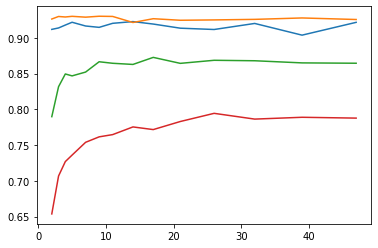

In [149]:
res = early_stop_searching(data_zoo)

In [150]:
res

{'elmo': {'epoch': [3,
   4,
   5,
   7,
   9,
   11,
   14,
   17,
   21,
   26,
   32,
   39,
   47,
   57,
   69,
   83,
   100,
   121,
   146,
   176],
  'f1': [0.9043245961470926,
   0.9084873693661416,
   0.9182548578317392,
   0.9196223000220608,
   0.9234456399161807,
   0.9237269005652166,
   0.924336003687206,
   0.9202922566181615,
   0.9203709739285296,
   0.9235350334105104,
   0.9229915715534052,
   0.9231711019094396,
   0.9248935165155556,
   0.9216746995445221,
   0.9231426432707426,
   0.9227649959921965,
   0.9204459120233626,
   0.9198141530868499,
   0.9216867220422037,
   0.9184523475054338]},
 'use': {'epoch': [3,
   4,
   5,
   7,
   9,
   11,
   14,
   17,
   21,
   26,
   32,
   39,
   47,
   57,
   69,
   83,
   100,
   121,
   146,
   176],
  'f1': [0.8603465906132868,
   0.8770008133289355,
   0.8817950134515902,
   0.8938368423856418,
   0.9043224186212103,
   0.9057743845101349,
   0.9104360541269809,
   0.9164684696433113,
   0.9175679359988688,
   0.92

In [151]:
best_early_stop = {}
for em in embedding_models:
    best_early_stop[em] = res[em]['epoch'][ np.argmax( np.array(res[em]['f1']))]
    print("The best epoch of", em ,"is: ", res[em]['epoch'][ np.argmax( np.array(res[em]['f1']))] )

The best epoch of elmo is:  47
The best epoch of use is:  83
The best epoch of nnlm is:  176
The best epoch of gnew is:  176


In [163]:
best_early_stop

{'elmo': 47, 'use': 83, 'nnlm': 176, 'gnew': 176}

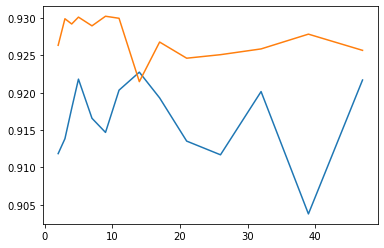

In [146]:
plt.plot(res['elmo']['epoch'], res['elmo']['f1'],res['use']['epoch'], res['use']['f1'])
plt.show()

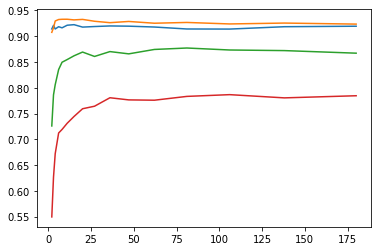

In [141]:
plt.plot(res['elmo']['epoch'], res['elmo']['f1'],res['use']['epoch'],\
         res['use']['f1'], res['nnlm']['epoch'], res['nnlm']['f1'], res['gnew']['epoch'],res['gnew']['f1'])
plt.show()

## Evaluation on the Test set

In [196]:
def evaluation_test_set(data_zoo):
    f1_test = {}
    
    for em in embedding_models:
        X_train, y_train = data_zoo[em]['dev']
        X_test, y_test = data_zoo[em]['test']
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Dense(numofclasses, activation='softmax'))
        model.compile(loss=best_hypter_parameter[em][0],\
                      optimizer=best_hypter_parameter[em][1], metrics=[metrics.mae, metrics.categorical_accuracy])
        model.fit(X_train, y_train, epochs=best_early_stop[em], batch_size = 128)
        model.summary()
        model.save_weights("topic_clustering_model/%s.h5"%em)
        f1_test[em] = f1_score_model(model, X_test, y_test)
    return f1_test

In [197]:
evaluation_test_set(data_zoo)

Train on 8136 samples
Epoch 1/47
8136/8136 [==============================] - 1s 90us/sample - loss: -0.6567 - mean_absolute_error: 0.1926 - categorical_accuracy: 0.7038
Epoch 2/47
8136/8136 [==============================] - 0s 38us/sample - loss: -0.8465 - mean_absolute_error: 0.1308 - categorical_accuracy: 0.8835
Epoch 3/47
8136/8136 [==============================] - 0s 37us/sample - loss: -0.8830 - mean_absolute_error: 0.1083 - categorical_accuracy: 0.9072
Epoch 4/47
8136/8136 [==============================] - 0s 38us/sample - loss: -0.9000 - mean_absolute_error: 0.0952 - categorical_accuracy: 0.9184
Epoch 5/47
8136/8136 [==============================] - 0s 37us/sample - loss: -0.9101 - mean_absolute_error: 0.0864 - categorical_accuracy: 0.9226
Epoch 6/47
8136/8136 [==============================] - 0s 38us/sample - loss: -0.9174 - mean_absolute_error: 0.0799 - categorical_accuracy: 0.9266
Epoch 7/47
8136/8136 [==============================] - 0s 38us/sample - loss: -0.9228 - m

8136/8136 [==============================] - 0s 34us/sample - loss: -0.9484 - mean_absolute_error: 0.0517 - categorical_accuracy: 0.9499
Epoch 59/83
8136/8136 [==============================] - 0s 33us/sample - loss: -0.9487 - mean_absolute_error: 0.0513 - categorical_accuracy: 0.9501
Epoch 60/83
8136/8136 [==============================] - 0s 32us/sample - loss: -0.9490 - mean_absolute_error: 0.0508 - categorical_accuracy: 0.9501
Epoch 61/83
8136/8136 [==============================] - 0s 34us/sample - loss: -0.9493 - mean_absolute_error: 0.0504 - categorical_accuracy: 0.9506
Epoch 62/83
8136/8136 [==============================] - 0s 33us/sample - loss: -0.9496 - mean_absolute_error: 0.0501 - categorical_accuracy: 0.9506
Epoch 63/83
8136/8136 [==============================] - 0s 34us/sample - loss: -0.9499 - mean_absolute_error: 0.0495 - categorical_accuracy: 0.9507
Epoch 64/83
8136/8136 [==============================] - 0s 41us/sample - loss: -0.9502 - mean_absolute_error: 0.0493 

8136/8136 [==============================] - 0s 32us/sample - loss: 0.7690 - mean_absolute_error: 0.1308 - categorical_accuracy: 0.8304
Epoch 27/176
8136/8136 [==============================] - 0s 32us/sample - loss: 0.7560 - mean_absolute_error: 0.1286 - categorical_accuracy: 0.8315
Epoch 28/176
8136/8136 [==============================] - 0s 34us/sample - loss: 0.7438 - mean_absolute_error: 0.1265 - categorical_accuracy: 0.8330
Epoch 29/176
8136/8136 [==============================] - 0s 32us/sample - loss: 0.7320 - mean_absolute_error: 0.1245 - categorical_accuracy: 0.8335
Epoch 30/176
8136/8136 [==============================] - 0s 31us/sample - loss: 0.7211 - mean_absolute_error: 0.1225 - categorical_accuracy: 0.8359
Epoch 31/176
8136/8136 [==============================] - 0s 31us/sample - loss: 0.7106 - mean_absolute_error: 0.1207 - categorical_accuracy: 0.8370
Epoch 32/176
8136/8136 [==============================] - 0s 31us/sample - loss: 0.7007 - mean_absolute_error: 0.1190 -

8136/8136 [==============================] - 0s 32us/sample - loss: 0.4932 - mean_absolute_error: 0.0787 - categorical_accuracy: 0.8677
Epoch 82/176
8136/8136 [==============================] - 0s 32us/sample - loss: 0.4912 - mean_absolute_error: 0.0783 - categorical_accuracy: 0.8679
Epoch 83/176
8136/8136 [==============================] - 0s 32us/sample - loss: 0.4895 - mean_absolute_error: 0.0780 - categorical_accuracy: 0.8685
Epoch 84/176
8136/8136 [==============================] - 0s 32us/sample - loss: 0.4878 - mean_absolute_error: 0.0776 - categorical_accuracy: 0.8690
Epoch 85/176
8136/8136 [==============================] - 0s 31us/sample - loss: 0.4862 - mean_absolute_error: 0.0773 - categorical_accuracy: 0.8684
Epoch 86/176
8136/8136 [==============================] - 0s 31us/sample - loss: 0.4845 - mean_absolute_error: 0.0769 - categorical_accuracy: 0.8681
Epoch 87/176
8136/8136 [==============================] - 0s 33us/sample - loss: 0.4829 - mean_absolute_error: 0.0766 -

KeyboardInterrupt: 

In [185]:
model_zoo = {}

In [200]:
em = 'use'

In [201]:
model_zoo[em] = tf.keras.Sequential()
model_zoo[em].add(tf.keras.layers.InputLayer(input_shape=[512, ]))
model_zoo[em].add(tf.keras.layers.Dense(numofclasses ,activation='softmax'))
model_zoo[em].compile(loss=best_hypter_parameter[em][0], optimizer=best_hypter_parameter[em][1],
             metrics=[metrics.mae, metrics.categorical_accuracy])
model_zoo[em].summary()
if os.path.exists("topic_clustering_model/%s.h5"%em):
    model_zoo[em].load_weights("topic_clustering_model/%s.h5"%em)

Model: "sequential_674"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_907 (Dense)            (None, 7)                 3591      
Total params: 3,591
Trainable params: 3,591
Non-trainable params: 0
_________________________________________________________________


In [208]:
X = ["Hello world", "I love you"]

In [209]:
X_use = np.array(USE(X))

In [210]:
X_use

array([[-0.02607428, -0.08460002, -0.02678666, ..., -0.02173567,
         0.01262516, -0.06147427],
       [ 0.03456973, -0.03164849,  0.00675156, ..., -0.04832186,
        -0.0031064 , -0.01271174]], dtype=float32)

In [213]:
np.argmax(model_zoo[em].predict(X_use), axis=1)

array([4, 5], dtype=int64)

In [ ]:
def prediction("")